# scRNA-Seq dataset [Candeli et al. (2025)](https://www....)

Single cell transcriptome analysis of NEr-fAOs

Show that while enriched for PNECs, NEr-fAOs retain diverse airway cell types, preserving epithelial complexity. We map PNEC trajectories in NEr-fAOs, uncovering precursor and mature states. Comparative analyses show that basal stem cells in NEr-fAOs acquire lower airway progenitor (LAP)-like signatures.

### Imports

In [6]:
import scvelo as scv
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
import os, tqdm
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import csv
from gtfparse import read_gtf
import hdf5plugin
import seaborn as sns
import scanpy.external as sce
from scipy.sparse import coo_matrix
import scipy
from scipy import sparse
from bioinfokit import analys, visuz
from sanbomics.plots import volcano
from adjustText import adjust_text
import leidenalg
import gseapy
import decoupler
from scipy import io
import anndata as ad
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib as mpl
from scipy.sparse import csr_matrix
import harmonypy as hm
import celltypist
from celltypist import models

### Figure Settings

In [7]:
# Set font types to ensure text is editable in Illustrator
mpl.rcParams['pdf.fonttype'] = 42   # For PDF export
mpl.rcParams['ps.fonttype'] = 42    # For PS export
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['savefig.dpi'] = 600

# Scanpy figure settings
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=600, 
                     frameon=False, vector_friendly=True, fontsize=12, 
                     figsize=(5,4), color_map=None, format='pdf', facecolor=None, 
                     transparent=False, ipython_format='png')

# scVelo figure settings
scv.set_figure_params(style='scvelo', dpi=80, dpi_save=600, 
                      frameon=False, vector_friendly=True, transparent=True, fontsize=12, 
                      figsize=(5,4), color_map=None, facecolor=None, format='pdf', ipython_format='png')

# Set figure directory
sc.settings.figdir = './../figures/'
scv.settings.figdir = './../figures/'

# Fine-tune Matplotlib settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['figure.subplot.wspace'] = 0.99
plt.rcParams['axes.grid'] = False

import logging
# Suppress INFO messages
logging.getLogger("fontTools").setLevel(logging.WARNING)
plt.set_loglevel('WARNING') 

### Custom colormap

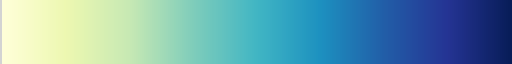

In [8]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Define the 'lightgrey' color as an RGBA tuple with values in the range 0-1
lightgrey_rgba = (0.83, 0.83, 0.83, 1.0)  # RGB values for lightgrey with alpha=1.0
# Get the 'YlGnBu' colormap
YlGnBu_cmap = plt.cm.get_cmap('YlGnBu')
# Define the number of steps for interpolation
num_steps = 256
# Define the range for values where lightgrey is used
lightgrey_range = 0.0
# Interpolate between light grey and blue for values from 0 to lightgrey_range
interpolated_colors_below = [lightgrey_rgba] + [YlGnBu_cmap(i) for i in np.linspace(0, 1, int(num_steps * lightgrey_range))]
# Interpolate between light grey and green for values from lightgrey_range to 1
interpolated_colors_above = [YlGnBu_cmap(i) for i in np.linspace(0, 1, int(num_steps * (1 - lightgrey_range)))]
# Combine the two sets of colors
interpolated_colors = interpolated_colors_below + interpolated_colors_above
# Create the custom colormap
cmap = LinearSegmentedColormap.from_list('custom_YlGnBu', interpolated_colors)
# Now you can use this custom colormap in your plots
cmap

### Inspect matrixes AnnData

In [9]:
import numpy as np
from scipy.sparse import issparse

def matrix_summary(adata):
    """
    Prints min, max, and mean for expression matrix, counts layer, raw matrix,
    and scaled layer of an AnnData object.

    Parameters:
        adata: AnnData
    """

    # Helper function to compute min, max, mean
    def summary(matrix, name):
        if issparse(matrix):
            matrix = matrix.toarray()
        flat = matrix.flatten()
        mean_value = flat.mean()
        print(f"{name}: min={flat.min()}, max={flat.max()}, mean={mean_value}")

    # Expression matrix
    summary(adata.X, "Expression matrix (X)")

    # Counts layer
    if 'counts' in adata.layers:
        summary(adata.layers['counts'], "Counts layer matrix (layers['counts'])")
    else:
        print("Counts layer not found in adata.layers.")

    # Raw matrix
    if adata.raw is not None:
        summary(adata.raw.X, "Raw matrix (raw.X)")
    else:
        print("Raw matrix not found in adata.raw.")

    # Scaled layer
    if 'scaled' in adata.layers:
        summary(adata.layers['scaled'], "Scaled layer matrix (layers['scaled'])")
    else:
        print("Scaled layer not found in adata.layers.")


### Volcano Plot

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

def plot_volcano(dataframes, top_genes=25, logfc_cutoff=1, pval_cutoff=0.05):
    for name, df in dataframes.items():
        prefix = name.split('_')[1]

        plt.figure(figsize=(8, 6))

        plt.scatter(x=df[f'{prefix}_logfoldchanges'], 
                    y=df[f'{prefix}_pvals_adj'].apply(lambda x: -np.log10(x)), 
                    s=1, label="Not significant", color='lightgray')

        down = df[(df[f'{prefix}_logfoldchanges'] <= -logfc_cutoff) & (df[f'{prefix}_pvals_adj'] <= pval_cutoff)]
        up = df[(df[f'{prefix}_logfoldchanges'] >= logfc_cutoff) & (df[f'{prefix}_pvals_adj'] <= pval_cutoff)]

        top_downregulated = down.sort_values(by=f'{prefix}_scores', ascending=True).head(top_genes)
        top_upregulated = up.sort_values(by=f'{prefix}_scores', ascending=False).head(top_genes)
        
        max_abs_logfc = max(np.ceil(abs(top_upregulated[f'{prefix}_logfoldchanges']).max()), np.ceil(abs(top_downregulated[f'{prefix}_logfoldchanges']).max()))
        xlim=(-max_abs_logfc-2,max_abs_logfc+2)

        plt.scatter(x=down[f'{prefix}_logfoldchanges'], 
                    y=down[f'{prefix}_pvals_adj'].apply(lambda x: -np.log10(x)), 
                    s=3, label="Down-regulated", color="blue")
        plt.scatter(x=up[f'{prefix}_logfoldchanges'], 
                    y=up[f'{prefix}_pvals_adj'].apply(lambda x: -np.log10(x)), 
                    s=3, label="Up-regulated", color="red")

        plt.title(f"Volcano Plot for {name}", y=1.1)
        plt.xlabel("logFC", fontsize=18)
        plt.xlim(xlim)
        plt.ylabel("-logFDR", fontsize=18)
        plt.axvline(-logfc_cutoff, color="grey", linestyle="--")
        plt.axvline(logfc_cutoff, color="grey", linestyle="--")
        plt.axhline(-np.log10(pval_cutoff), color="grey", linestyle="--")
        plt.legend(loc='center', bbox_to_anchor=(0.5, 1.01, 0, 0.1),fontsize=14,markerscale=5,ncols=3)

        texts = []
        for i, r in top_downregulated.iterrows():
            texts.append(plt.text(x=r[f'{prefix}_logfoldchanges'], 
                                  y=-np.log10(r[f'{prefix}_pvals_adj']),
                                  s=r[f'{prefix}_names'], 
                                  fontsize=7, 
                                  fontweight='heavy',
                                  color='blue', 
                                  ha='center', 
                                  va='bottom'))

        for i, r in top_upregulated.iterrows():
            texts.append(plt.text(x=r[f'{prefix}_logfoldchanges'], 
                                  y=-np.log10(r[f'{prefix}_pvals_adj']),
                                  s=r[f'{prefix}_names'], 
                                  fontsize=7, 
                                  fontweight='heavy',
                                  color='red', 
                                  ha='center', 
                                  va='bottom'))

        adjust_text(texts, arrowprops=dict(arrowstyle='-', connectionstyle='arc3', color='k'))

        plt.savefig(f'./figures/Volcano_plot_Std_NE_exp_{name}',bbox_inches='tight')
        plt.show()

# DEG Media

In [11]:
adata=sc.read_h5ad('./../data/NEr_fAOs_annotated.h5ad')
adata

AnnData object with n_obs × n_vars = 5441 × 32191
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'S_score', 'G2M_score', 'phase', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'AT1', 'AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor', 'Club-like Secretory', 'Deuterosomal', 'Goblet', 'Goblet-like Secretory', 'Ionocyte', 'Lower Airway Progenitor', 'MEC', 'Mucous', 'Multiciliated', 'PNEC', 'RAS', 'SMG Basal/Duct', 'Secretory', 'Serous', 'Suprabasal', 'Tuft', 'Unknown', 'CELLTYPIST', 'PNEC_Signature', 'CELLTYPIST_media', 'CELL_TYPE'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rp', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'CELLTYPIST_colors', 'CELLTYPIST_media_colors', 'CE

## Figure 6A

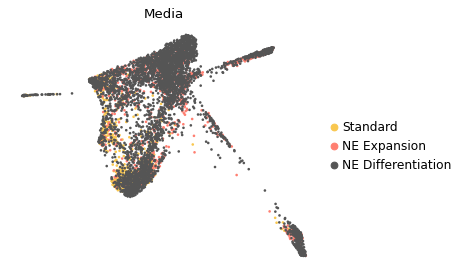

In [12]:
sc.pl.draw_graph(adata,color='Media',cmap=cmap, vmin=1e-10,use_raw=True,frameon=False,save='_Std_NE_Exp_media')

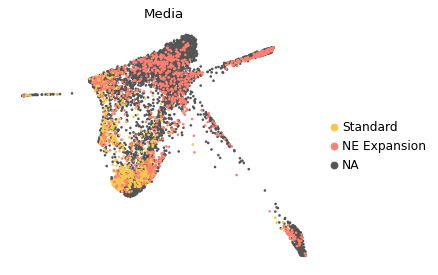

In [13]:
## Figure 6A
sc.pl.draw_graph(adata,color='Media',groups=['Standard','NE Expansion'],na_color='#555555',
           cmap=cmap, vmin=1e-10,use_raw=True,frameon=False,save='_Std_NE_Exp_media_conditions')

## Figure 6B

In [14]:
condition_mask = adata.obs['Media'].isin(['NE Expansion','Standard'])
adata_std_exp = adata[condition_mask]
adata_std_exp

View of AnnData object with n_obs × n_vars = 1473 × 32191
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'S_score', 'G2M_score', 'phase', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'AT1', 'AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor', 'Club-like Secretory', 'Deuterosomal', 'Goblet', 'Goblet-like Secretory', 'Ionocyte', 'Lower Airway Progenitor', 'MEC', 'Mucous', 'Multiciliated', 'PNEC', 'RAS', 'SMG Basal/Duct', 'Secretory', 'Serous', 'Suprabasal', 'Tuft', 'Unknown', 'CELLTYPIST', 'PNEC_Signature', 'CELLTYPIST_media', 'CELL_TYPE'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rp', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'CELLTYPIST_colors', 'CELLTYPIST_media_colo

In [15]:
#adata.uns['log1p']['base']= None
sc.tl.rank_genes_groups(adata_std_exp,'Media',method='wilcoxon',key_added='NE_exp_vs_Std')

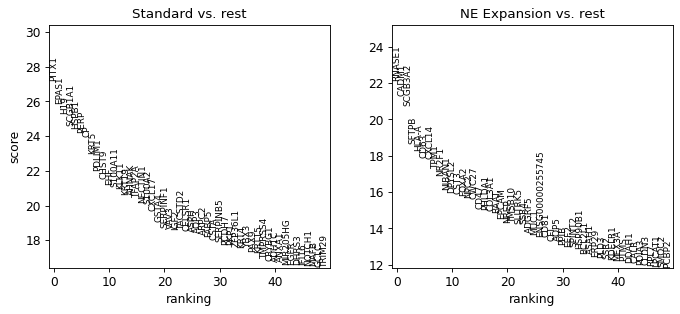

In [16]:
sc.pl.rank_genes_groups(adata_std_exp, n_genes=50, sharey=False, key="NE_exp_vs_Std",save='_Conditions_NE_exp_vs_Std_media')

In [17]:
output_file = "./../data/markers/NE_exp_vs_Std_media_DEG.xlsx"

with pd.ExcelWriter(output_file, engine="xlsxwriter") as writer:
    for media in adata_std_exp.obs['Media'].unique():
        media_DEG = sc.get.rank_genes_groups_df(
            adata_std_exp,
            group=media,
            key='NE_exp_vs_Std'
        )
        
        # Excel sheet names must be <= 31 characters
        sheet_name = f"Media_{media}"[:31]
        media_DEG.to_excel(writer, sheet_name=sheet_name, index=False)


In [18]:
result = adata_std_exp.uns['NE_exp_vs_Std']
groups = result['names'].dtype.names

data_frames = {}  # Dictionary to store separate data frames

for group in groups:
    df = pd.DataFrame({
        group + '_' + key[:20]: result[key][group]
        for key in ['names', 'logfoldchanges', 'pvals', 'pvals_adj', 'scores']
    })
    data_frames[group] = df

# Accessing individual data frames
for group, df in data_frames.items():
    # Do something with each individual data frame
    print(f"Group: {group}")
    print(df)
    df.to_csv('./../data/markers/Markers_{}_NE_exp_vs_Std_media.csv'.format(group))

Group: Standard
      Standard_names  Standard_logfoldchanges  Standard_pvals  \
0              PITX1                 7.579850   7.719672e-163   
1              EPAS1                 3.957645   2.255273e-147   
2                H19                 4.002934   7.626968e-141   
3            SCGB1A1                 3.649883   1.450051e-133   
4              HSPB1                 2.000919   2.032281e-131   
...              ...                      ...             ...   
32186          HLA-A                -1.459459    8.998617e-75   
32187          SFTPB                -3.313938    1.881666e-77   
32188        SCGB3A2                -4.725443    1.582279e-95   
32189          CADM1                -2.808503   8.641984e-101   
32190         RNASE1                -3.093452   1.397650e-108   

       Standard_pvals_adj  Standard_scores  
0           2.485040e-158        27.193657  
1           3.629974e-143        25.852932  
2           8.183991e-137        25.265629  
3           1.166965e-1

In [19]:
new_df= pd.DataFrame({})
new_dfs={}

for group, df1 in data_frames.items():
    # Inside the nested loop
    for column_name in df1.columns:
        if column_name.endswith('_names'):
            prefix = column_name.split("_")[0]

            # Check if the specified key exists in df1.columns
            if f'{prefix}_scores' in df1.columns and f'{prefix}_pvals_adj' in df1.columns and f'{prefix}_logfoldchanges' in df1.columns and f'{prefix}_names' in df1.columns:
                # Define the variables within this scope
                scores_column_name = f'{prefix}_scores'
                pval_column_name = f'{prefix}_pvals_adj'
                logfoldchanges_column_name = f'{prefix}_logfoldchanges'
                symbols_column_name = f'{prefix}_names'
    
                # Create a new dataframe with the specified structure
                new_df = pd.DataFrame({
                    scores_column_name: df1[f'{prefix}_scores'],
                    pval_column_name: df1[f'{prefix}_pvals_adj'].replace(0.000000e+00, 1e-300),
                    logfoldchanges_column_name: df1[f'{prefix}_logfoldchanges'],
                    symbols_column_name: df1[f'{prefix}_names']
                })
            
                new_df.set_index(df1[column_name].str.upper(), inplace=True)
                new_dfs[f'deg_{prefix}'] = new_df
            else:
                print(f"Columns for {prefix} not found in df1.")
new_dfs

{'deg_Standard':                 Standard_scores  Standard_pvals_adj  Standard_logfoldchanges  \
 Standard_names                                                                 
 PITX1                 27.193657       2.485040e-158                 7.579850   
 EPAS1                 25.852932       3.629974e-143                 3.957645   
 H19                   25.265629       8.183991e-137                 4.002934   
 SCGB1A1               24.594400       1.166965e-129                 3.649883   
 HSPB1                 24.392939       1.308423e-127                 2.000919   
 ...                         ...                 ...                      ...   
 HLA-A                -18.295431        8.778014e-72                -1.459459   
 SFTPB                -18.628662        2.329719e-74                -3.313938   
 SCGB3A2              -20.737726        3.183447e-92                -4.725443   
 CADM1                -21.312775        2.318284e-97                -2.808503   
 RNASE1     

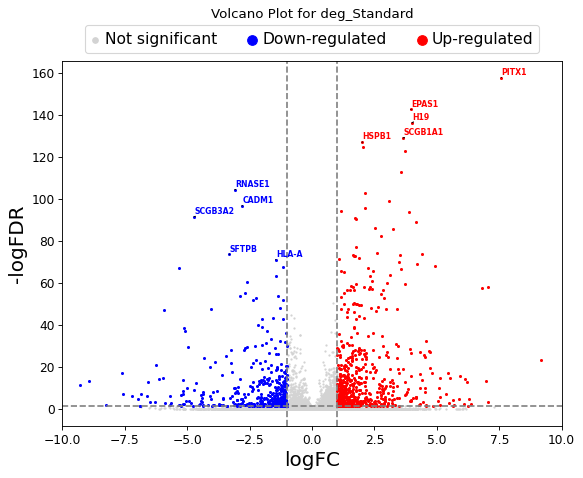

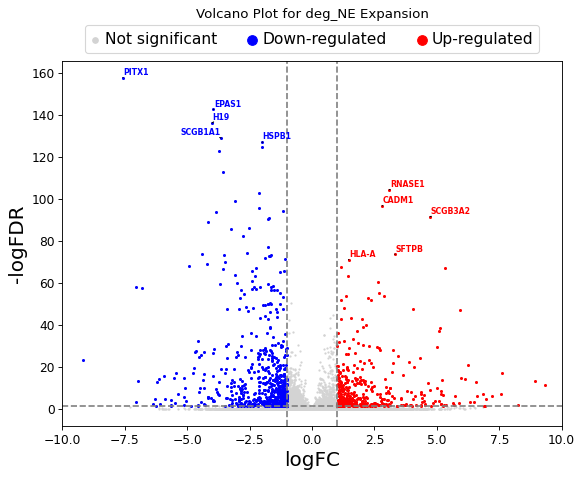

In [20]:
## Figure 6B
plot_volcano(new_dfs, top_genes=5, logfc_cutoff=1, pval_cutoff=0.05)

In [21]:
adata_std_exp.obs['Media_CELLTYPE'] = adata_std_exp.obs['Media'].astype(str) + '_' + adata_std_exp.obs['CELL_TYPE'].astype(str) 

... storing 'Media_CELLTYPE' as categorical


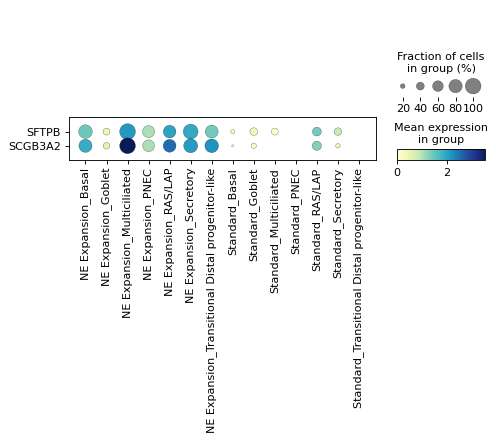

In [23]:
# Figure 6C
sc.pl.dotplot(adata_std_exp,['SFTPB','SCGB3A2'],groupby='Media_CELLTYPE',
                 swap_axes=True,
                 cmap=cmap, save='_Std_NEexp_distal_markers_celltype_media')

# Subset Basal cells
## Figures S6B-C

In [24]:
adata=sc.read_h5ad('./../data/NEr_fAOs_annotated.h5ad')
adata

AnnData object with n_obs × n_vars = 5441 × 32191
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'S_score', 'G2M_score', 'phase', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'AT1', 'AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor', 'Club-like Secretory', 'Deuterosomal', 'Goblet', 'Goblet-like Secretory', 'Ionocyte', 'Lower Airway Progenitor', 'MEC', 'Mucous', 'Multiciliated', 'PNEC', 'RAS', 'SMG Basal/Duct', 'Secretory', 'Serous', 'Suprabasal', 'Tuft', 'Unknown', 'CELLTYPIST', 'PNEC_Signature', 'CELLTYPIST_media', 'CELL_TYPE'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rp', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'CELLTYPIST_colors', 'CELLTYPIST_media_colors', 'CE

In [25]:
# Create a boolean mask based on your condition
condition_mask = (
    adata.obs['CELL_TYPE'].isin(['Basal']) &
    adata.obs['Media'].isin(['NE Expansion', 'Standard'])
)

adata_basal = adata[condition_mask]
cells_ID = adata_basal.obs_names
len(cells_ID)

717

In [26]:
adata_raw=sc.read_h5ad('./../data/STARsolo.velocyto_NEr-fAOs.h5ad')
adata_raw

AnnData object with n_obs × n_vars = 5817 × 32245
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week'
    var: 'gene_ids', 'feature_types', 'n_cells'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [27]:
condition_mask = adata_raw.obs_names.isin(cells_ID)
adata_basal = adata_raw[condition_mask]
adata_basal

View of AnnData object with n_obs × n_vars = 717 × 32245
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week'
    var: 'gene_ids', 'feature_types', 'n_cells'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [28]:
adata_NErfAOs=sc.read_h5ad('./../data/NEr_fAOs_annotated.h5ad')
adata_NErfAOs.obs['cluster']=adata_NErfAOs.obs['leiden']
adata_basal.obs['cluster']=adata_NErfAOs.obs['cluster']
adata_basal.obs['CELL_TYPE']=adata_NErfAOs.obs['CELL_TYPE']
adata_basal.obs

,Sample ID,Media,Time point,Patient ID,Passage,Gestational Week,cluster,CELL_TYPE
s003.1,s003,Standard,day0-std,124e,P4,week_14,5,Basal
s003.3,s003,Standard,day0-std,124e,P4,week_14,5,Basal
s003.4,s003,Standard,day0-std,124e,P4,week_14,0,Basal
s003.5,s003,Standard,day0-std,124e,P4,week_14,0,Basal
s003.8,s003,Standard,day0-std,124e,P4,week_14,0,Basal
...,...,...,...,...,...,...,...,...
s001.284,s001,NE Expansion,day0,125e,P6,week_17,0,Basal
s001.286,s001,NE Expansion,day0,125e,P6,week_17,0,Basal
s001.287,s001,NE Expansion,day0,125e,P6,week_17,5,Basal
s001.288,s001,NE Expansion,day0,125e,P6,week_17,4,Basal


In [29]:
sc.pp.filter_genes(adata_basal, min_cells=3)
adata_basal.var

,gene_ids,feature_types,n_cells
ENSG00000238009,ENSG00000238009.6,Gene Expression,6
ENSG00000268903,ENSG00000268903.1,Gene Expression,29
ENSG00000241860,ENSG00000241860.7,Gene Expression,22
ENSG00000228463,ENSG00000228463.10,Gene Expression,29
ENSG00000290385,ENSG00000290385.1,Gene Expression,26
...,...,...,...
MT-ND6,ENSG00000198695.2,Gene Expression,233
MT-TE,ENSG00000210194.1,Gene Expression,11
MT-CYB,ENSG00000198727.2,Gene Expression,717
MT-TT,ENSG00000210195.2,Gene Expression,5


## Normalization & Highly Variable Genes

In [30]:
# Save counts layer
adata_basal.layers["counts"] = adata_basal.X.copy()

#  Normalize counts per cell.
# Normalize each cell by total counts over all genes, so that every cell has the same total count after normalization
sc.pp.normalize_total(adata_basal, target_sum=1e4)

#Logarithmize the data matrix.
#Computes X = log (X=1), where X denotes the natural logarithm unless a different base is given.
sc.pp.log1p(adata_basal)

adata_basal.raw = adata_basal.copy()
adata_basal

AnnData object with n_obs × n_vars = 717 × 20920
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week', 'cluster', 'CELL_TYPE'
    var: 'gene_ids', 'feature_types', 'n_cells'
    uns: 'log1p'
    layers: 'ambiguous', 'spliced', 'unspliced', 'counts'

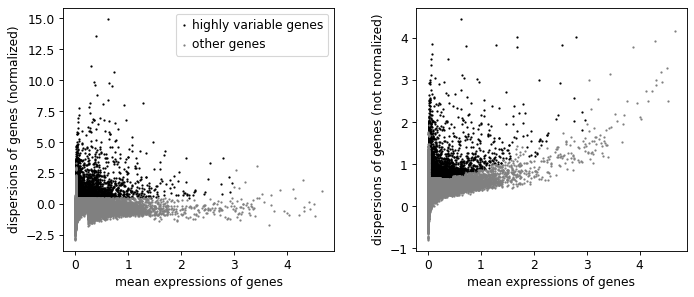

In [31]:
# highly-variable genes are selected
sc.pp.highly_variable_genes(adata_basal, layer=None, n_top_genes=None, min_disp=0.5, min_mean=0.0125,
                                max_mean=3, span=0.3, n_bins=20, flavor='seurat', 
                                subset=False, inplace=True,batch_key=None, check_values=True)
sc.pl.highly_variable_genes(adata_basal)

## Regress out (mostly) unwanted sources of variation.

In [32]:
# Parsing of Cell Cycle genes file
cell_cycle_genes = [x.strip() for x in open ('./../data/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata_basal.var_names]

In [33]:
# Score all genes using our S and G2M phase gene lists
sc.tl.score_genes_cell_cycle(adata_basal, s_genes=s_genes, g2m_genes=g2m_genes)

... storing 'phase' as categorical


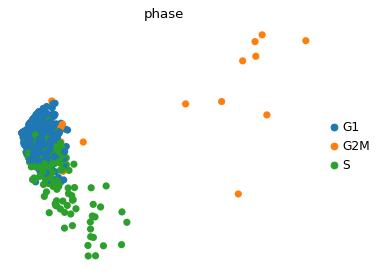

In [34]:
# We will plot the PCA of the cell cycle genes' source of variation
adata_cc_genes = adata_basal[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color= 'phase')

In [35]:
adata_basal.var['mt'] = adata_basal.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_basal, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata_basal.var['rp'] = adata_basal.var_names.str.startswith('RP')  # annotate the group of ribosomal genes as 'rp'
sc.pp.calculate_qc_metrics(adata_basal, qc_vars=['rp'], percent_top=None, log1p=False, inplace=True)

... storing 'phase' as categorical


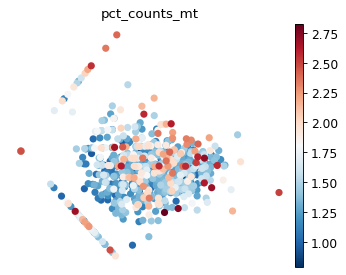

In [36]:
# We will plot the PCA of the mitochondrial genes' source of variation
adata_mt_genes = adata_basal[:, adata_basal.var_names.str.startswith('MT-')]
sc.tl.pca(adata_mt_genes)
sc.pl.pca_scatter(adata_mt_genes, color='pct_counts_mt')

... storing 'phase' as categorical


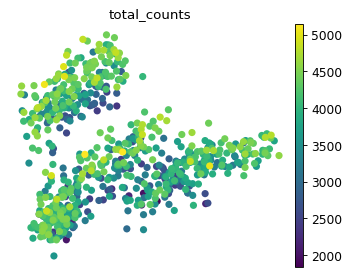

In [37]:
# We will plot the PCA of the total counts' source of variation
adata_hvg = adata_basal[:, adata_basal.var['highly_variable']]
sc.tl.pca(adata_hvg)
sc.pl.pca_scatter(adata_hvg, color='total_counts', cmap='viridis')

In [38]:
# Regress out the unwanted sources of variation.
sc.pp.regress_out(adata_basal, ["total_counts", "pct_counts_mt",'S_score','G2M_score'])

... storing 'phase' as categorical


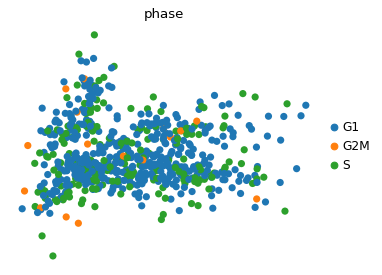

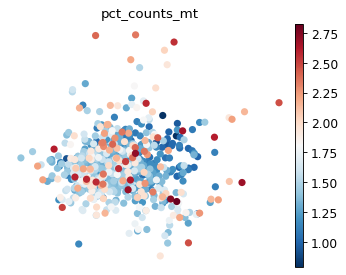

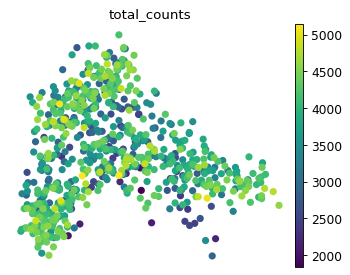

In [39]:
# Plot PCA again after regression
adata_cc_genes = adata_basal[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color= 'phase')
adata_mt_genes = adata_basal[:, adata_basal.var_names.str.startswith('MT-')]
sc.tl.pca(adata_mt_genes)
sc.pl.pca_scatter(adata_mt_genes, color='pct_counts_mt')
adata_hvg = adata_basal[:, adata_basal.var['highly_variable']]
sc.tl.pca(adata_hvg)
sc.pl.pca_scatter(adata_hvg, color='total_counts', cmap='viridis')

## Scaling of the data

In [40]:
# Scale data to unit variance and zero mean store results in layer
# Variables (genes) that do not display any variation (are constant across all observations) 
# are retained and set to 0 during this operation. In the future, they might be set to NaNs.

adata_basal.layers["scaled"] = sc.pp.scale(adata_basal, copy=True).X
adata_basal

AnnData object with n_obs × n_vars = 717 × 20920
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week', 'cluster', 'CELL_TYPE', 'S_score', 'G2M_score', 'phase', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rp'
    uns: 'log1p', 'hvg'
    layers: 'ambiguous', 'spliced', 'unspliced', 'counts', 'scaled'

## Compute PCA

In [41]:
sc.tl.pca(adata_basal, n_comps=50, use_highly_variable=True, svd_solver='arpack')

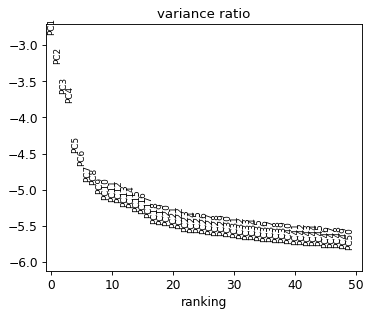

In [42]:
sc.pl.pca_variance_ratio(adata_basal, log=True,n_pcs=50)

In [43]:
sc.pp.neighbors(adata_basal, n_neighbors=30, n_pcs=25)
sc.tl.draw_graph(adata_basal)

2026-01-30 13:21:50.132158: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-30 13:21:50.132255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-30 13:21:50.169222: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-30 13:22:04.237468: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


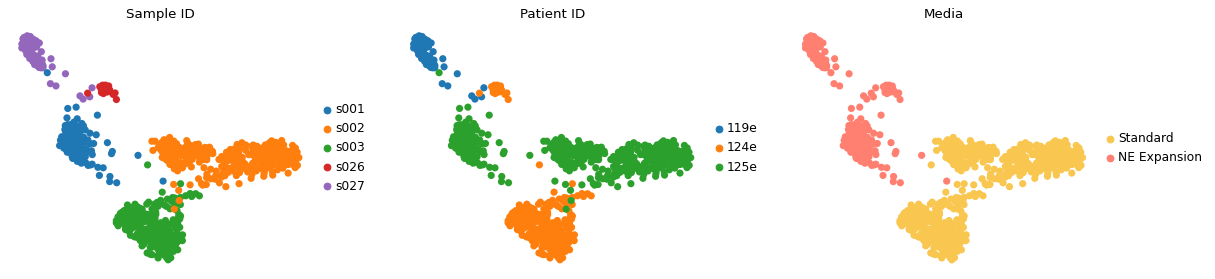

In [44]:
custom_order = ['Standard','NE Expansion']
custom_dtype = pd.CategoricalDtype(categories=custom_order, ordered=True)
adata_basal.obs['Media'] = adata_basal.obs['Media'].astype(custom_dtype)
adata_basal.uns['Media_colors']= ['#F9C74F','#FF7F71']

sc.pl.draw_graph(adata_basal, color=['Sample ID','Patient ID','Media'],save='_Basal_NOT_harmonized')

In [45]:
sc.external.pp.harmony_integrate(adata_basal, ['Sample ID'], basis='X_pca', adjusted_basis='X_pca_harmony')

2026-01-30 13:22:30,370 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2026-01-30 13:22:32,638 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2026-01-30 13:22:32,643 - harmonypy - INFO - Iteration 1 of 50
INFO:harmonypy:Iteration 1 of 50
2026-01-30 13:22:33,714 - harmonypy - INFO - Iteration 2 of 50
INFO:harmonypy:Iteration 2 of 50
2026-01-30 13:22:34,814 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


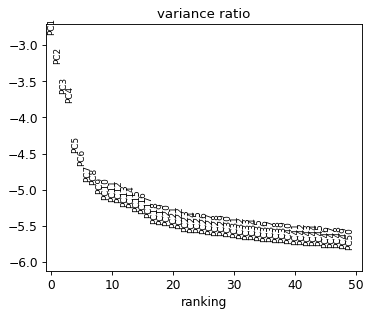

In [46]:
adata_basal.obsm['prev_X_pca'] = adata_basal.obsm['X_pca']
adata_basal.obsm['X_pca'] = adata_basal.obsm['X_pca_harmony']

sc.pl.pca_variance_ratio(adata_basal, log=True,n_pcs=50)

In [47]:
sc.pp.neighbors(adata_basal, n_neighbors=30, n_pcs=25)
sc.tl.draw_graph(adata_basal)

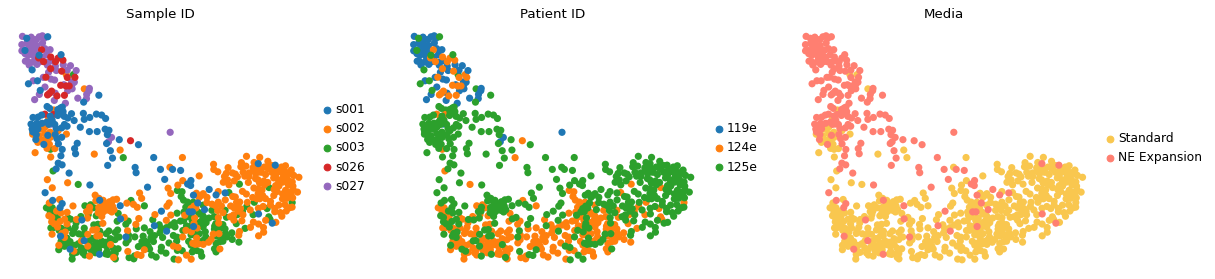

In [48]:
sc.pl.draw_graph(adata_basal, color=['Sample ID','Patient ID','Media'],save='_Basal_harmonized')

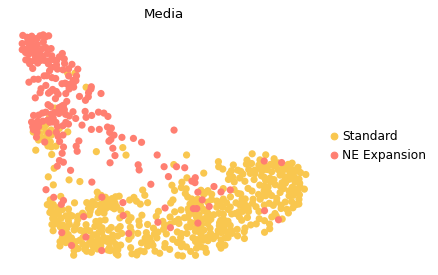

In [49]:
## Figure S6A
sc.pl.draw_graph(adata_basal, color=['Media'], save='_Basal_Media')

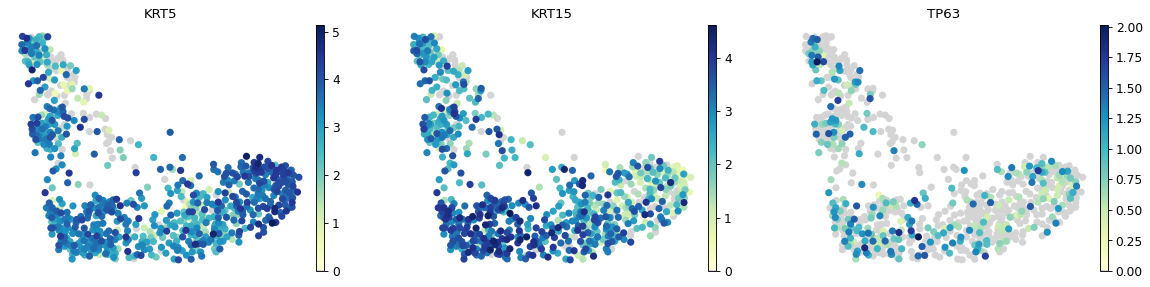

In [60]:
## Figure S6B
sc.pl.draw_graph(adata_basal, color=['KRT5','KRT15','TP63'],cmap=cmap, save='_Basal_Media')

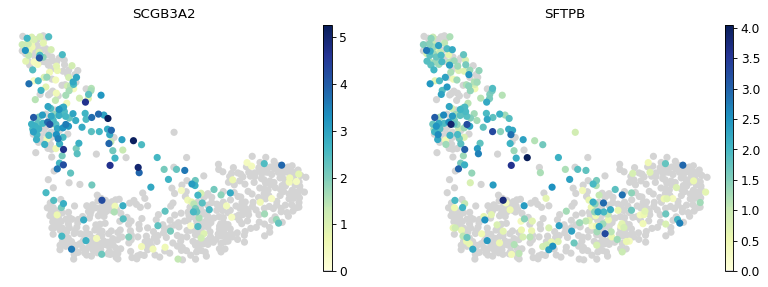

In [61]:
## Figure S6C
sc.pl.draw_graph(adata_basal, color=['SCGB3A2','SFTPB'],cmap=cmap, save='_Basal_Media')

In [52]:
adata_basal.write_h5ad('./../data/Basal.h5ad',
    compression=hdf5plugin.FILTERS["zstd"],
    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)

## Export Extracted Basal cells (for scHPF)

In [53]:
adata_basal=sc.read_h5ad('./../data/Basal.h5ad')
adata_basal

AnnData object with n_obs × n_vars = 717 × 20920
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week', 'cluster', 'CELL_TYPE', 'S_score', 'G2M_score', 'phase', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rp'
    uns: 'Media_colors', 'Patient ID_colors', 'Sample ID_colors', 'draw_graph', 'hvg', 'log1p', 'neighbors', 'pca'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_pca_harmony', 'prev_X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'counts', 'scaled', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [54]:
adata_basal=sc.read_h5ad('./../data/Basal.h5ad')
columns_to_keep = ['Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week', 'cluster', 'CELL_TYPE']
columns_to_remove = [column for column in adata_basal.obs.columns if column not in columns_to_keep]
adata_basal.obs = adata_basal.obs.drop(columns=columns_to_remove)
adata_basal

AnnData object with n_obs × n_vars = 717 × 20920
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week', 'cluster', 'CELL_TYPE'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rp'
    uns: 'Media_colors', 'Patient ID_colors', 'Sample ID_colors', 'draw_graph', 'hvg', 'log1p', 'neighbors', 'pca'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_pca_harmony', 'prev_X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'counts', 'scaled', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [55]:
import scipy.sparse as sp
from scipy.io import mmwrite
import io

mmwrite('./../data/Basal_matrix.mtx', adata_basal.layers['counts'])

In [56]:
# Write gene names to tsv
with open ('./../data/Basal_var_genes.tsv','w') as f:
    for item in adata_basal.var_names:
        f.write(item + '\n')

In [57]:
# Write cell names to tsv
with open ('./../data/Basal_obs_cells.tsv','w') as f:
    for item in adata_basal.obs_names:
        f.write(item + '\n')

In [58]:
# Write metadata to csv
df = pd.DataFrame(adata_basal.obs)
df.to_csv('./../data/Basal_metadata.csv', index=False)
df

,Sample ID,Media,Time point,Patient ID,Passage,Gestational Week,cluster,CELL_TYPE
s003.1,s003,Standard,day0-std,124e,P4,week_14,5,Basal
s003.3,s003,Standard,day0-std,124e,P4,week_14,5,Basal
s003.4,s003,Standard,day0-std,124e,P4,week_14,0,Basal
s003.5,s003,Standard,day0-std,124e,P4,week_14,0,Basal
s003.8,s003,Standard,day0-std,124e,P4,week_14,0,Basal
...,...,...,...,...,...,...,...,...
s001.284,s001,NE Expansion,day0,125e,P6,week_17,0,Basal
s001.286,s001,NE Expansion,day0,125e,P6,week_17,0,Basal
s001.287,s001,NE Expansion,day0,125e,P6,week_17,5,Basal
s001.288,s001,NE Expansion,day0,125e,P6,week_17,4,Basal
